In [35]:
%load_ext autoreload
%autoreload 2

import os
device_count = 30
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={device_count}"

from kinn_function import initialize_training, train, batched_state, errors_uptake, \
    encode_reactions, batched_model, diff_state, uncertainty_analysis, load_data_y, loss_uptake
import jax.numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
zone_lengths = {'zone0': 2.80718, 'zone1': 0.17364, 'zone2': 2.80718}
zone_porosity = {'zone0':0.4, 'zone1':0.4, 'zone2':0.4}
radius = 1.

pulse_num = 10
pulse_train = [0, 1, 2, 5, 8]
pulse_test = [3, 4, 6, 7, 9]
mass = np.array([28.01, 32, 44.01])
reactants = ['CO','O2']
products = ['CO2']

In [3]:
data_train, data_test = load_data_y('../../data/TAP_experimental_data.json', zone_lengths,
                              zone_porosity, mass, reactants, products, 
                              pulse_num, pulse_train, pulse_test, n_species=6,
                              radius=radius, add_noise=0.5)

In [11]:
err_tags = ['Data','Uptake','Total Site','Model']
num_epochs = 1000
num_iter = 10
rxn = ['CO + * <-> CO*',
       'O2 + 2* -> 2O*',
       'CO* + O* <-> CO2 + 2*',
       'CO + O* -> CO2 + *']
species = ['CO','O2','CO2','CO*','O*','*']
encoded_rxn = encode_reactions(rxn,species)
weighted_param = np.array([1e-1, 1e-2, 1e-2, 1e-5])

layer_sizes = [1+len(reactants+products), 10, 10, 6]
model_size = [6]
params, opt_inv = initialize_training(layer_sizes, model_size, param_file = None)

In [12]:
# The loop below is set up to mimic the manual changing of the weighted_param value, but please note
# it cannot fully replicate the manual fine-tuning process. It is just a sample demonstration of how
# the weighted_param value can be changed during training.
# If you have any question about the detail tunning of weighted parameter, please contact dnai3@gatech.edu

for j in range(3):
    cycle = 7 - j//2
    for i in range(cycle):
        params = train(params,data_train,num_epochs,num_iter,opt_inv,err_tags,
                             encoded_rxn,device_count,weighted_param, 
                             ferrors=errors_uptake, loss=loss_uptake)
        [params, opt_inv] = params
        nn_params_inv, model_params_inv = params
        nn_params = nn_params_inv
        model_params = model_params_inv
    weighted_param *= 5

[2.5e+00 2.5e-01 2.5e-01 2.5e-04]
Epoch:  999, Loss Batch: 8.36776e+02, Fit Data: 2.21211e+01, Fit Uptake: 6.80162e+02, Fit Total Site: 8.76928e+00, Fit Model: 1.25724e+02
[Array([-6.10814179,  1.41404495, -0.18341861,  0.30609132,  0.02798627,
        6.64451101], dtype=float64)]


In [38]:
standard_deviation = uncertainty_analysis(params, data_train, weighted_param/5, encoded_rxn)

/var/tmp/pbs.2443534.sawtoothpbs/ipykernel_27020/3021764775.py:54: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


Text(0.01, 0.31, 'Testing set')

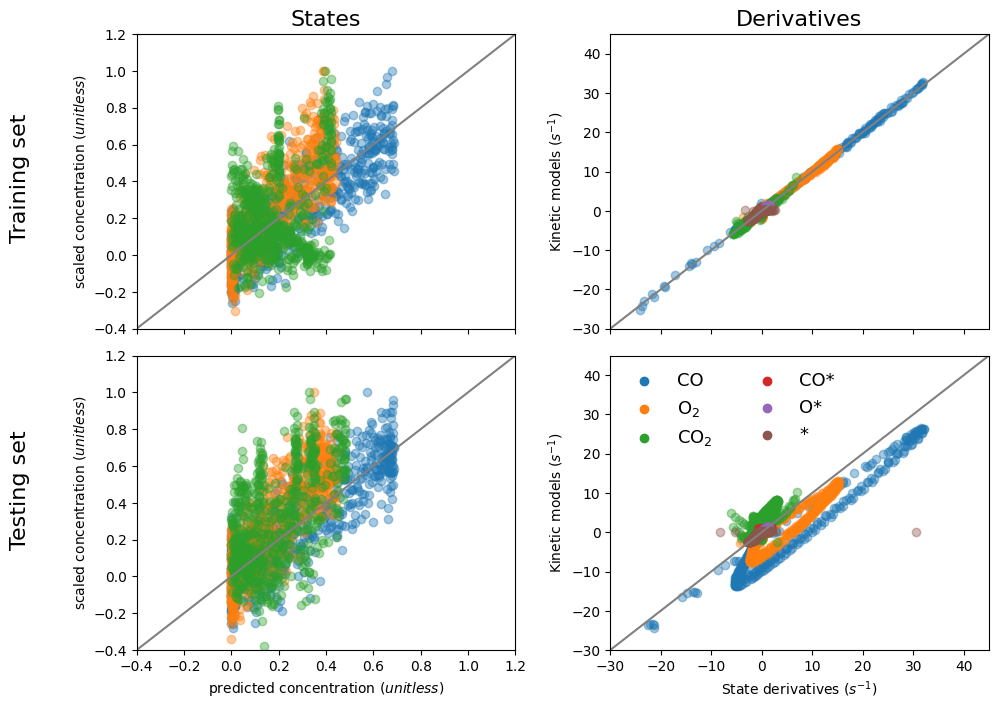

In [22]:
# The code below shows how we generate the figure in the paper. Since the training block above is set up only to
# mimic the manual weighted parameter tuning process, and the model is not validated through validation, it may not
# exactly match the figure we show in the paper. If you want to generate the same figure, please use the parameters we
# provide in file multi_prac.npz in the results folder using the param_file arguments in initialize_training() function.

# If you have any question about the figure generation, please contact dnai3@gatech.edu

y_train, t_train, net_flux_train, _ = data_train[0]
data_scale = data_train[1]
y_test, t_test, net_flux_test, _ = data_test[0]
data_test_scale = data_test[1]

fig = plt.figure(figsize = (11,8))

gs = gridspec.GridSpec(4, 2, figure = fig)
gs.update(wspace=0.25)

ax1 = fig.add_subplot(gs[:2, 0])
for i in range(3):
    ax1.scatter(batched_state(nn_params, t_train)[:,i],y_train[:,i], 
                color = 'C{}'.format(i), alpha = 0.4)
ax1.set(xlim=(-0.4, 1.2), ylim=(-0.4, 1.2))
ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="-", c = '.5')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_title('States', fontsize = 16)
ax1.set_ylabel('scaled concentration $(unitless)$')

ax2 = fig.add_subplot(gs[2:, 0], sharex = ax1)
for i in range(3):
    ax2.scatter(batched_state(nn_params, t_test)[:,i],y_test[:,i], 
                color = 'C{}'.format(i), alpha = 0.4)
ax2.set(xlim=(-0.4, 1.2), ylim=(-0.4, 1.2))
ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="-", c = '.5')
ax2.set_xlabel('predicted concentration $(unitless)$')
ax2.set_ylabel('scaled concentration $(unitless)$')

ax3 = fig.add_subplot(gs[:2, 1])
for i in range(6):
    ax3.scatter((diff_state(nn_params,t_train) / np.exp(t_train[:,0:1]))[:,i],
            batched_model([batched_state(nn_params,t_train),t_train], 
                          model_params, net_flux_train, data_scale, encoded_rxn)[:,i] / data_scale[i],
               color = 'C{}'.format(i), alpha = 0.4)
ax3.set(xlim=(-30, 45), ylim=(-30, 45))
ax3.plot(ax3.get_xlim(), ax3.get_ylim(), ls="-", c = '.5')
plt.setp(ax3.get_xticklabels(), visible=False)
ax3.set_title('Derivatives', fontsize = 16)
ax3.set_ylabel('Kinetic models $(s^{-1})$')

ax4 = fig.add_subplot(gs[2:, 1], sharex = ax3)
for i in range(6):
    ax4.scatter((diff_state(nn_params,t_test)/ np.exp(t_test[:,0:1]))[:,i],
        batched_model([batched_state(nn_params,t_test),t_test], 
                      model_params, net_flux_test, data_test_scale, encoded_rxn)[:,i] /data_test_scale[i],
               color = 'C{}'.format(i), alpha = 0.4)
ax4.set(xlim=(-30, 45), ylim=(-30, 45))
ax4.plot(ax4.get_xlim(), ax4.get_ylim(), ls="-", c = '.5')
leg = ax4.legend(['CO', 'O$_2$', 'CO$_2$', 'CO*', 'O*','*'], ncol = 2,  prop={'size': 13}, frameon = False)
ax4.set_xlabel('State derivatives $(s^{-1})$')
ax4.set_ylabel('Kinetic models $(s^{-1})$')

for lh in leg.legendHandles: 
    lh.set_alpha(1)

fig.text(0.01, 0.7, 'Training set', va='center', fontsize = 16, rotation='vertical')
fig.text(0.01, 0.31, 'Testing set', va='center', fontsize = 16, rotation='vertical')

Text(0.5, 0, '$k_{TRUE}$')

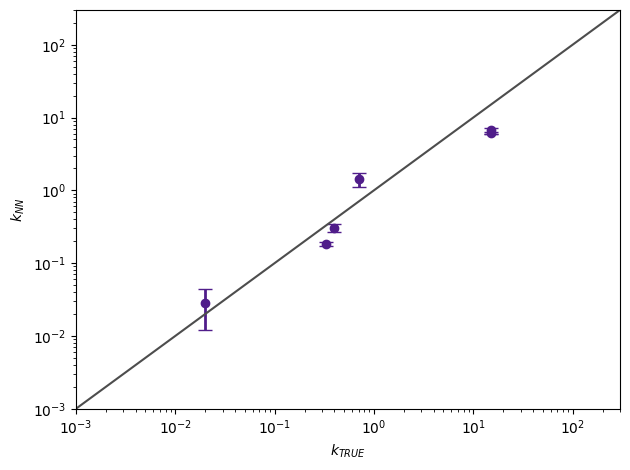

In [41]:
model_params_true = np.array([15, 0.7, 0.33, 0.4, 0.02, 15.2])
model_params_fit = np.abs(model_params_inv[0])

model_params_err = standard_deviation

fig, axs = plt.subplots(tight_layout = True)

axs.errorbar(model_params_true, model_params_fit, yerr = model_params_err, fmt = 'o',
               color = '#501d8a', elinewidth = 2, capsize = 5)
axs.set_yscale('log')
axs.set_xscale('log')
axs.set(xlim=(0.001, 300), ylim=(0.001, 300))
axs.plot(axs.get_xlim(), axs.get_ylim(), ls="-", c = '.3')
axs.set_ylabel('$k_{NN}$')
axs.set_xlabel('$k_{TRUE}$')